In [4]:
import sys
sys.path.append('..')
import torch
import os
import torch.nn as nn
import torchvision
from torch.utils.data.dataloader import DataLoader
from torch.utils.data.dataset import Dataset
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import random
from models.CycleGAN import *
from datasets.UnalignedDataset import UnalignedDataset
from utils.utils import ImageBuffer, set_requires_grad, tensor_to_image, save_cyclegan_model

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [5]:
def init_weights(m):
    if isinstance(m, nn.Conv2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.normal_(m.bias, 0.0)

In [6]:
transform = transforms.Compose([transforms.Resize((140, 140), Image.BICUBIC),
                                transforms.RandomCrop(128),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])])

In [7]:
train_dataset = UnalignedDataset('/home/dpakhom1/Cycle_gan_pytorch/datasets/people2anime/',
                              ["trainA", "anime-faces-clean"], limit=400, transform=transform)
val_dataset = UnalignedDataset('/home/dpakhom1/Cycle_gan_pytorch/datasets/people2anime/',
                              ["valA", "anime-faces-clean"], limit=400, transform=transform)

In [8]:
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=1, num_workers=2)
val_dataloader = DataLoader(val_dataset, shuffle=True, batch_size=1, num_workers=2)

<IPython.core.display.Javascript object>


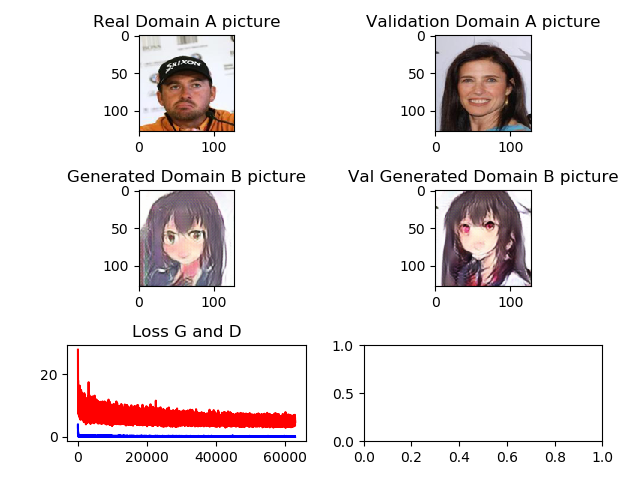

In [9]:
%matplotlib notebook
f, (real_pics, gen_pics, loss_axis) = plt.subplots(3, 2)
real_pics[0].set_title("Real Domain A picture")
gen_pics[0].set_title("Generated Domain B picture")
loss_axis[0].set_title("Loss G and D")
real_pics[1].set_title("Validation Domain A picture")
gen_pics[1].set_title("Val Generated Domain B picture")
#real_pic.plot()
#gen_pic.plot()
loss_d = []
loss_g = []
loss_axis[0].plot(loss_d, list(range(len(loss_d))), 'b',
               loss_g, list(range(len(loss_g))), 'r')
plt.tight_layout()

In [14]:
def train_loop(num_epochs, train_dataloader, G1, G2, D1, D2):
    optimizer_G = optim.Adam(list(G1.parameters()) + list(G2.parameters()), lr=0.0002, betas=(0.5, 0.999))
    optimizer_D = optim.Adam(list(D1.parameters()) + list(D2.parameters()), lr=0.0002, betas=(0.5, 0.999))
    img_bufferA = ImageBuffer(50)
    img_bufferB = ImageBuffer(50)
    lr = 0.0002
    for epoch in range(num_epochs):

        if epoch % 50 == 49:
            save_cyclegan_model(G1, G2, D1, D2, '/home/dpakhom1/Cycle_gan_pytorch/', epoch + 1)
            
        if epoch > 100:
            for param_group in optimizer_G.param_groups:
                param_group['lr'] = max(lr - 0.00002, 0)
            for param_group in optimizer_D.param_groups:
                param_group['lr'] = max(lr - 0.00002, 0)
                
        for idx, data in enumerate(train_dataloader):
            domain_A, domain_B = data["A"].cuda(), data["B"].cuda()
            
            fake_B, cycle_BA, fake_A, cycle_AB = calc_Gs_outputs(G1, G2, domain_A, domain_B)
            
            set_requires_grad([D1, D2], False)
            optimizer_G.zero_grad()
            loss_G = backward_Gs(fake_B, cycle_BA, fake_A, cycle_AB, domain_A, domain_B, G1, G2, D1, D2)
            loss_g.append(loss_G.item())
            
            optimizer_G.step()
            #if idx % 5 == 4:
            set_requires_grad([D1, D2], True)
            optimizer_D.zero_grad()
            
            
            
            fake_A = img_bufferA.update(fake_A)
            loss_D1 = backward_D(domain_A, fake_A, D1)
            fake_B = img_bufferB.update(fake_B)
            loss_D2 = backward_D(domain_B, fake_B, D2)
            loss_d.append((loss_D1.item() + loss_D2.item())/2)
            optimizer_D.step()
            
            if idx % 200 == 199:
                print("Epoch: ", epoch + 1, "\n", "Gen loss: ", loss_G, "\n", "Discr loss: ", (loss_D1 + loss_D2)/2)

            if idx % 20 == 19:
                with torch.no_grad():
                    real_pics[0].imshow(tensor_to_image(torch.squeeze(data["A"])))
                    #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
                    real_pics[0].relim()
                    real_pics[0].autoscale_view()
                    real_pics[0].figure.canvas.draw()
                    G1.eval()
                    output = G1(domain_A)
                    output = (((np.transpose(torch.squeeze(fake_B.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
                    #output = transforms.ToPILImage()(torch.squeeze(fake_B.cpu())).convert("RGB")
                    gen_pics[0].imshow(output)
                    gen_pics[0].relim()
                    gen_pics[0].autoscale_view()
                    gen_pics[0].figure.canvas.draw()
                    G1.train()
                    
                    loss_axis[0].lines[0].set_xdata(list(range(len(loss_d))))
                    loss_axis[0].lines[0].set_ydata(loss_d)
                    loss_axis[0].lines[1].set_xdata(list(range(len(loss_g))))
                    loss_axis[0].lines[1].set_ydata(loss_g)
                    loss_axis[0].relim()
                    loss_axis[0].autoscale_view()
                    loss_axis[0].figure.canvas.draw()
        for data in val_dataloader:
            with torch.no_grad():
                domain_A = data["A"].cuda()
                real_pics[1].imshow(tensor_to_image(torch.squeeze(data["A"])))
                #real_pic.imshow(np.transpose(torch.squeeze(domain_A).cpu().detach().numpy(), (1, 2, 0)))
                real_pics[1].relim()
                real_pics[1].autoscale_view()
                real_pics[1].figure.canvas.draw()
                G1.eval()
                fake_B = G1(domain_A)
                output = (((np.transpose(torch.squeeze(fake_B.detach().cpu()).numpy(), (1, 2, 0)) + 1)/2)*255).astype(np.uint8)
                #output = transforms.ToPILImage()(torch.squeeze(fake_B.cpu())).convert("RGB")
                gen_pics[1].imshow(output)
                gen_pics[1].relim()
                gen_pics[1].autoscale_view()
                gen_pics[1].figure.canvas.draw()
                G1.train()
            break

In [15]:
def load_models(G1, G2, D1, D2):
    G1.load_state_dict(torch.load('./g1_good.pth'))
    G2.load_state_dict(torch.load('./g2_good.pth'))
    D1.load_state_dict(torch.load('./d1_good.pth'))
    D2.load_state_dict(torch.load('./d2_good.pth'))

In [16]:
G1 = ResnetGenerator(3, 9, norm_type='instance')
G2 = ResnetGenerator(3, 9, norm_type='instance')
D1 = PatchGan(3, norm_type='instance')
D2 = PatchGan(3, norm_type='instance')
G1.train()
G2.train()
D1.train()
D2.train()
G1 = G1.cuda()
G2 = G2.cuda()
D1 = D1.cuda()
D2 = D2.cuda()
#load_models(G1, G2, D1, D2)

In [17]:
G1.apply(init_weights);
G2.apply(init_weights);
D1.apply(init_weights);
D2.apply(init_weights);

In [ ]:
train_loop(200, train_dataloader, G1, G2, D1, D2)

/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Epoch:  1 
 Gen loss:  tensor(10.1431, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2455, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  1 
 Gen loss:  tensor(7.6286, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2641, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  2 
 Gen loss:  tensor(9.2017, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2641, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  2 
 Gen loss:  tensor(8.2451, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2011, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  3 
 Gen loss:  tensor(9.4525, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2308, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  3 
 Gen loss:  tensor(6.4371, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2973, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  4 
 Gen loss:  tensor(10.3230, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  11 
 Gen loss:  tensor(6.0955, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0883, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  11 
 Gen loss:  tensor(7.8140, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2329, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  12 
 Gen loss:  tensor(6.7084, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1252, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  12 
 Gen loss:  tensor(8.3836, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1393, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  13 
 Gen loss:  tensor(8.4603, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1454, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  13 
 Gen loss:  tensor(8.4093, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2748, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  14 
 Gen loss:  tensor(6.5819, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0739, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  14 
 Gen loss:  tensor(6.8984, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0955, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  15 
 Gen loss:  tensor(6.3718, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0422, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  15 
 Gen loss:  tensor(6.9744, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1175, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  16 
 Gen loss:  tensor(5.2517, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0834, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  16 
 Gen loss:  tensor(6.7362, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1365, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  17 
 Gen loss:  tensor(4.9290, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0828, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  17 
 Gen loss:  tensor(8.1586, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1524, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  18 
 Gen loss:  tensor(5.0674, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  21 
 Gen loss:  tensor(5.4508, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0712, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  21 
 Gen loss:  tensor(8.5413, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2652, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  22 
 Gen loss:  tensor(6.4392, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2233, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  22 
 Gen loss:  tensor(6.9215, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0738, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  23 
 Gen loss:  tensor(7.6058, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1366, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  23 
 Gen loss:  tensor(5.6163, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1418, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  24 
 Gen loss:  tensor(7.1845, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authke

Epoch:  37 
 Gen loss:  tensor(6.4466, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1357, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  37 
 Gen loss:  tensor(6.3948, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2292, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  38 
 Gen loss:  tensor(5.1655, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1200, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  38 
 Gen loss:  tensor(6.7869, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1073, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authke

Epoch:  39 
 Gen loss:  tensor(5.7680, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1094, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  39 
 Gen loss:  tensor(4.9546, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1190, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  40 
 Gen loss:  tensor(4.7228, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1335, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  40 
 Gen loss:  tensor(5.0083, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1121, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  41 
 Gen loss:  tensor(4.5020, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1044, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  41 
 Gen loss:  tensor(4.5652, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1335, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  42 
 Gen loss:  tensor(8.2838, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1059, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  42 
 Gen loss:  tensor(5.1462, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1132, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  43 
 Gen loss:  tensor(4.7056, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  52 
 Gen loss:  tensor(4.5538, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0940, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  52 
 Gen loss:  tensor(6.2441, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1179, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  53 
 Gen loss:  tensor(4.9358, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1447, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  53 
 Gen loss:  tensor(4.9096, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1319, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  54 
 Gen loss:  tensor(7.3123, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2328, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  54 
 Gen loss:  tensor(5.9702, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1168, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  55 
 Gen loss:  tensor(4.4514, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1684, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  55 
 Gen loss:  tensor(4.2158, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1003, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  56 
 Gen loss:  tensor(4.5979, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1155, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  56 
 Gen loss:  tensor(5.2099, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0887, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  57 
 Gen loss:  tensor(5.4312, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1348, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  57 
 Gen loss:  tensor(6.4261, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1838, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  58 
 Gen loss:  tensor(6.2135, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0823, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  58 
 Gen loss:  tensor(5.4951, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1456, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  59 
 Gen loss:  tensor(6.1693, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1187, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  59 
 Gen loss:  tensor(5.9863, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1825, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  60 
 Gen loss:  tensor(6.0398, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0846, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  60 
 Gen loss:  tensor(4.7906, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1165, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  61 
 Gen loss:  tensor(4.9803, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  73 
 Gen loss:  tensor(3.8558, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2005, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  73 
 Gen loss:  tensor(6.2328, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2095, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  74 
 Gen loss:  tensor(4.6065, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1038, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  74 
 Gen loss:  tensor(4.5375, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2027, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  75 
 Gen loss:  tensor(5.4838, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1708, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  75 
 Gen loss:  tensor(4.7843, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1301, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  76 
 Gen loss:  tensor(4.9198, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2102, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  76 
 Gen loss:  tensor(4.8725, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1140, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  77 
 Gen loss:  tensor(5.3429, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1724, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  77 
 Gen loss:  tensor(5.7763, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0516, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  78 
 Gen loss:  tensor(4.7156, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1065, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  78 
 Gen loss:  tensor(5.5844, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1530, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  79 
 Gen loss:  tensor(5.2079, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authke

Epoch:  80 
 Gen loss:  tensor(4.9639, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.2191, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  80 
 Gen loss:  tensor(5.6228, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0951, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  81 
 Gen loss:  tensor(5.5694, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0655, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  81 
 Gen loss:  tensor(5.4782, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1454, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  82 
 Gen loss:  tensor(4.8060, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0802, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  82 
 Gen loss:  tensor(6.5770, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1338, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  83 
 Gen loss:  tensor(6.1869, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0633, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  83 
 Gen loss:  tensor(5.3838, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1387, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  84 
 Gen loss:  tensor(5.0002, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0755, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  84 
 Gen loss:  tensor(5.4562, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0815, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  85 
 Gen loss:  tensor(5.8097, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0873, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  85 
 Gen loss:  tensor(5.6545, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0711, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  86 
 Gen loss:  tensor(4.7721, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1320, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  86 
 Gen loss:  tensor(5.0368, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0518, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  87 
 Gen loss:  tensor(4.9460, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  88 
 Gen loss:  tensor(4.6641, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1566, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  88 
 Gen loss:  tensor(4.7264, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1564, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  89 
 Gen loss:  tensor(6.2748, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1093, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  89 
 Gen loss:  tensor(7.4525, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1438, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  90 
 Gen loss:  tensor(4.5805, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1279, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  90 
 Gen loss:  tensor(4.0438, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1335, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  91 
 Gen loss:  tensor(5.7270, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1765, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  91 
 Gen loss:  tensor(4.7885, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1726, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  92 
 Gen loss:  tensor(7.6671, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0930, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  92 
 Gen loss:  tensor(3.7769, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1066, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  93 
 Gen loss:  tensor(6.6644, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0907, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  93 
 Gen loss:  tensor(6.0127, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1227, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  94 
 Gen loss:  tensor(4.6060, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  101 
 Gen loss:  tensor(4.8803, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0989, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  101 
 Gen loss:  tensor(3.3677, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1604, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  102 
 Gen loss:  tensor(4.8883, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1010, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  102 
 Gen loss:  tensor(5.0438, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1116, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  103 
 Gen loss:  tensor(4.7281, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1048, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  103 
 Gen loss:  tensor(4.5826, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1072, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  104 
 Gen loss:  tensor(4.7090, device='cuda:0', grad_fn=<ThAddBackward>) 

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  106 
 Gen loss:  tensor(4.2384, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1441, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  106 
 Gen loss:  tensor(3.7208, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1019, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  107 
 Gen loss:  tensor(4.6714, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0920, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  107 
 Gen loss:  tensor(4.6301, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1265, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  108 
 Gen loss:  tensor(4.6173, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1349, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  108 
 Gen loss:  tensor(5.0033, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1235, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  109 
 Gen loss:  tensor(5.4910, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1121, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  109 
 Gen loss:  tensor(6.3058, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0948, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  110 
 Gen loss:  tensor(6.4492, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0577, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  110 
 Gen loss:  tensor(3.6681, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1375, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  111 
 Gen loss:  tensor(4.5247, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1546, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  111 
 Gen loss:  tensor(4.3079, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0859, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  112 
 Gen loss:  tensor(6.1637, device='cuda:0', grad_fn=<ThAddBackward>) 

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  130 
 Gen loss:  tensor(3.8865, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1228, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  130 
 Gen loss:  tensor(4.3243, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1523, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  131 
 Gen loss:  tensor(4.6112, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0747, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  131 
 Gen loss:  tensor(4.9667, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0741, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  132 
 Gen loss:  tensor(4.5491, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1981, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  132 
 Gen loss:  tensor(4.5290, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0961, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  133 
 Gen loss:  tensor(3.6995, device='cuda:0', grad_fn=<ThAddBackward>) 

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 58, in detach
    return reduction.recv_handle(conn)
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/reduction.py", line 185, in recv_handle
    return recvfds(s, 1)[0]
  File "/home/dpakhom1/anaconda

Epoch:  140 
 Gen loss:  tensor(5.0093, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0720, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  140 
 Gen loss:  tensor(5.4221, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0818, device='cuda:0', grad_fn=<DivBackward0>)


Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authke

Epoch:  141 
 Gen loss:  tensor(5.6264, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0977, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  141 
 Gen loss:  tensor(4.2772, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0909, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  142 
 Gen loss:  tensor(3.8768, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0703, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  142 
 Gen loss:  tensor(4.2621, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1262, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  143 
 Gen loss:  tensor(4.6312, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0927, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  143 
 Gen loss:  tensor(3.2987, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1504, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  144 
 Gen loss:  tensor(5.0155, device='cuda:0', grad_fn=<ThAddBackward>) 

Exception ignored in: <function _DataLoaderIter.__del__ at 0x7ff9d956cd08>
Traceback (most recent call last):
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 399, in __del__
    self._shutdown_workers()
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/utils/data/dataloader.py", line 378, in _shutdown_workers
    self.worker_result_queue.get()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/queues.py", line 354, in get
    return _ForkingPickler.loads(res)
  File "/home/dpakhom1/anaconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 151, in rebuild_storage_fd
    fd = df.detach()
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/dpakhom1/anaconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 87, in get_connection
    c = Client(address, authke

Epoch:  146 
 Gen loss:  tensor(4.8049, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0921, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  146 
 Gen loss:  tensor(5.9503, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0716, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  147 
 Gen loss:  tensor(4.1703, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1148, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  147 
 Gen loss:  tensor(5.6009, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.0681, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  148 
 Gen loss:  tensor(3.8383, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1288, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  148 
 Gen loss:  tensor(4.8711, device='cuda:0', grad_fn=<ThAddBackward>) 
 Discr loss:  tensor(0.1396, device='cuda:0', grad_fn=<DivBackward0>)
Epoch:  149 
 Gen loss:  tensor(4.4125, device='cuda:0', grad_fn=<ThAddBackward>) 

In [28]:
def save_models(G1, G2, D1, D2):
    torch.save(G1.state_dict(), './g1_best_anime.pth')
    torch.save(G2.state_dict(), './g2_best_anime.pth')
    torch.save(D1.state_dict(), './d1_best_anime.pth')
    torch.save(D2.state_dict(), './d2_best_anime.pth')

In [29]:
save_models(G1, G2, D1, D2)